# Week 2.2: Introduction to Attention Mechanisms

## Overview
In this notebook, we'll explore the fundamental concept of *attention* in Transformer models. Attention mechanisms are the core innovation that allowed Transformers to revolutionize NLP and eventually lead to modern Large Language Models (LLMs).

We'll break down the mathematics behind self-attention, implement it step by step, and understand how it enables models to capture relationships between words regardless of their distance in a sequence.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F

## 1. The Problem: Context in Language Modeling

Let's start by understanding the fundamental challenge that attention solves. From analysing simple character level n-gram models, we observed how incorporating longer context (from single characters to n-characters to words) resulted in "sentence completers" that produced more "interesting" generations.

Before the Transformer architecture, other neural network architectures (like RNNs and LSTMs) attempted to lean into the idea of capturing long-range dependencies, but faced many constraints. These models processed words sequentially, and information from early words would get diluted as the sequence grew longer.

A simple theoretical example of a long-range dependency:
- "The cat, which was sitting on the mat, **purrs**."
- "The cats, which were sitting on the mat, **purr**."

The verb at the end needs to agree with the subject at the beginning, even though they're separated by several words.

## 2. The Key Insight: Direct Access Through Attention

The breakthrough idea in attention is surprisingly simple: **let each word directly access every other word in the sequence**.

Instead of forcing information to flow through a chain of sequential operations, attention creates direct pathways between any two positions in a sequence.

This simple idea has profound implications, as it allows the model to:
- Capture long-range dependencies with ease
- Process sequences in parallel rather than sequentially
- Learn which connections are important for a given task

## 3. Self-Attention: Mathematical Intuition

At its core, self-attention is about computing weighted averages of a sequence. The weights are determined by how relevant each token is to the current token being processed.

Let's break down the mathematics step by step:

1. **Queries, Keys, and Values**:
   For each token in our sequence, we compute three vectors:
   - Query (Q): What information is this token looking for?
   - Key (K): What information does this token contain?
   - Value (V): The actual content/information of this token

2. **Attention Scores**:
   We compute how much each token should attend to every other token by taking the dot product of queries and keys:
   - Score = Q · K^T

3. **Scaling and Softmax**:
   - Scale the scores by 1/√(dimension of keys) to prevent vanishing gradients
   - Apply softmax to get normalized attention weights

4. **Weighted Sum**:
   - Multiply attention weights by value vectors and sum them up
   - This gives us the output of the attention mechanism

Mathematically, the self-attention operation is:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where:
- Q, K, V are matrices containing the queries, keys, and values for all tokens
- d_k is the dimension of the keys

## 4. Visualizing Self-Attention

Let's visualize self-attention for a simple example to build intuition. We'll create a toy sequence and see how attention works.

In [2]:
# Define a simple sequence
sequence_length = 4
d_model = 8  # Embedding dimension

# Random embedding vectors for 4 tokens
torch.manual_seed(42)  # For reproducibility
embeddings = torch.randn(sequence_length, d_model)
print("Token embeddings:")
print(embeddings)

Token embeddings:
tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047],
        [-0.7521,  1.6487, -0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624],
        [ 1.6423, -0.1596, -0.4974,  0.4396, -0.7581,  1.0783,  0.8008,  1.6806],
        [ 1.2791,  1.2964,  0.6105,  1.3347, -0.2316,  0.0418, -0.2516,  0.8599]])


In [3]:
# Create random projection matrices for Q, K, V
d_k = d_model  # Dimension of queries and keys
d_v = d_model  # Dimension of values

W_q = torch.randn(d_model, d_k)
W_k = torch.randn(d_model, d_k)
W_v = torch.randn(d_model, d_v)

# Compute Q, K, V
Q = embeddings @ W_q  # Shape: [sequence_length, d_k]
K = embeddings @ W_k  # Shape: [sequence_length, d_k]
V = embeddings @ W_v  # Shape: [sequence_length, d_v]

print("Queries shape:", Q.shape)
print("Keys shape:", K.shape)
print("Values shape:", V.shape)

Queries shape: torch.Size([4, 8])
Keys shape: torch.Size([4, 8])
Values shape: torch.Size([4, 8])


In [4]:
# Compute attention scores
scores = Q @ K.transpose(0, 1)  # Shape: [sequence_length, sequence_length]
print("Attention scores (before scaling):")
print(scores)

# Scale scores
scores = scores / (d_k ** 0.5)
print("\nAttention scores (after scaling):")
print(scores)

Attention scores (before scaling):
tensor([[ 48.3592,  -1.4314,   7.0602,  16.1742],
        [  1.8840,  14.5877, -10.8521, -11.8844],
        [-20.8970,  -3.9824,  16.8504,   5.9619],
        [  7.2162,   3.6702,  49.6052,  35.6275]])

Attention scores (after scaling):
tensor([[17.0975, -0.5061,  2.4962,  5.7184],
        [ 0.6661,  5.1575, -3.8368, -4.2018],
        [-7.3882, -1.4080,  5.9575,  2.1079],
        [ 2.5513,  1.2976, 17.5381, 12.5962]])


In [5]:
# Apply softmax to get attention weights
weights = F.softmax(scores, dim=-1)
print("Attention weights:")
print(weights)

# Verify that weights sum to 1 for each token
print("\nRow sums (should all be 1.0):")
print(weights.sum(dim=1))

Attention weights:
tensor([[9.9999e-01, 2.2638e-08, 4.5571e-07, 1.1432e-05],
        [1.1078e-02, 9.8871e-01, 1.2271e-04, 8.5188e-05],
        [1.5654e-06, 6.1913e-04, 9.7855e-01, 2.0830e-02],
        [3.0778e-07, 8.7853e-08, 9.9291e-01, 7.0906e-03]])

Row sums (should all be 1.0):
tensor([1., 1., 1., 1.])


In [6]:
# Compute weighted sum of values
output = weights @ V  # Shape: [sequence_length, d_v]
print("Self-attention output:")
print(output)

Self-attention output:
tensor([[-3.6925,  0.7997,  9.4704, -2.5174, -6.2702, -0.8382, -3.9583, -3.3199],
        [-1.7831,  5.1673,  3.8020,  2.5630, -3.0025,  1.5952,  0.3802,  5.1056],
        [-5.2188,  3.3771, -5.2385,  0.9001,  3.2845, -0.4186,  3.6742, -0.9937],
        [-5.2142,  3.4009, -5.2754,  0.8955,  3.3392, -0.3942,  3.6949, -1.0621]])


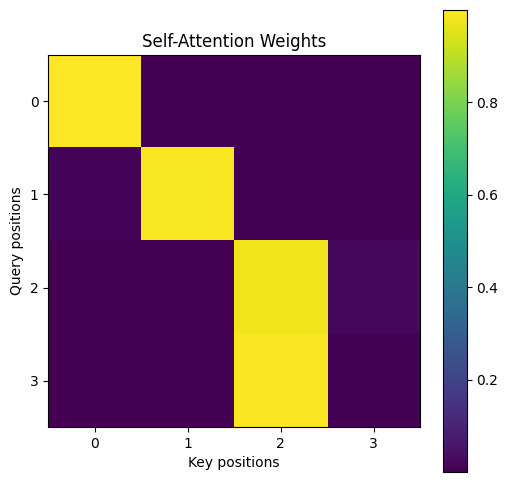

In [7]:
# Visualize attention weights
plt.figure(figsize=(6, 6))
plt.imshow(weights.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('Self-Attention Weights')
plt.xlabel('Key positions')
plt.ylabel('Query positions')
plt.xticks(np.arange(sequence_length))
plt.yticks(np.arange(sequence_length))
plt.grid(False)
plt.show()

## 5. Implementing Self-Attention in PyTorch

Now, let's implement self-attention as a PyTorch module.

In [8]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, d_k=None, d_v=None):
        super().__init__()
        d_k = d_k or d_model
        d_v = d_v or d_model
        
        self.d_k = d_k
        self.W_q = nn.Linear(d_model, d_k, bias=False)
        self.W_k = nn.Linear(d_model, d_k, bias=False)
        self.W_v = nn.Linear(d_model, d_v, bias=False)
        self.W_o = nn.Linear(d_v, d_model, bias=False)
        
    def forward(self, x, mask=None):
        # x shape: [batch_size, sequence_length, d_model]
        batch_size, sequence_length, _ = x.shape
        
        # Compute Q, K, V
        Q = self.W_q(x)  # [batch_size, sequence_length, d_k]
        K = self.W_k(x)  # [batch_size, sequence_length, d_k]
        V = self.W_v(x)  # [batch_size, sequence_length, d_v]
        
        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)  # [batch_size, sequence_length, sequence_length]
        
        # Apply mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        weights = F.softmax(scores, dim=-1)  # [batch_size, sequence_length, sequence_length]
        
        # Compute weighted sum of values
        output = torch.matmul(weights, V)  # [batch_size, sequence_length, d_v]
        
        # Apply output projection
        output = self.W_o(output)  # [batch_size, sequence_length, d_model]
        
        return output, weights

In [9]:
# Test our implementation
batch_size = 2
sequence_length = 4
d_model = 8

# Create random input tensor
x = torch.randn(batch_size, sequence_length, d_model)

# Initialize self-attention module
self_attention = SelfAttention(d_model)

# Forward pass
output, weights = self_attention(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {weights.shape}")

Input shape: torch.Size([2, 4, 8])
Output shape: torch.Size([2, 4, 8])
Attention weights shape: torch.Size([2, 4, 4])


## 6. Masked Self-Attention for Language Modeling

In language modeling, we want to predict the next token based only on previous tokens. To prevent the model from "cheating" by looking at future tokens, we use a mask that hides future positions.

Let's implement masked self-attention:

In [10]:
def create_causal_mask(sequence_length):
    """Create a causal mask for masked self-attention."""
    # Lower triangular matrix of ones
    mask = torch.tril(torch.ones(sequence_length, sequence_length))
    return mask

# Example
mask = create_causal_mask(5)
print("Causal mask for sequence_length=5:")
print(mask)

Causal mask for sequence_length=5:
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])


In [11]:
# Test masked self-attention
batch_size = 1
sequence_length = 5
d_model = 8

# Create random input tensor
x = torch.randn(batch_size, sequence_length, d_model)

# Create causal mask
mask = create_causal_mask(sequence_length).unsqueeze(0)  # Add batch dimension

# Initialize self-attention module
self_attention = SelfAttention(d_model)

# Forward pass with mask
output, weights = self_attention(x, mask)

print("Masked attention weights (each row shows which positions a token can attend to):")
print(weights[0])  # First batch

Masked attention weights (each row shows which positions a token can attend to):
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2605, 0.7395, 0.0000, 0.0000, 0.0000],
        [0.2025, 0.1859, 0.6116, 0.0000, 0.0000],
        [0.2658, 0.2540, 0.0900, 0.3901, 0.0000],
        [0.1623, 0.2064, 0.1695, 0.2603, 0.2015]], grad_fn=<SelectBackward0>)


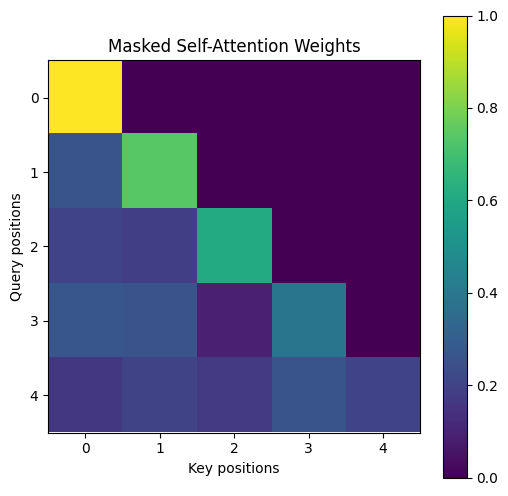

In [12]:
# Visualize masked attention
plt.figure(figsize=(6, 6))
plt.imshow(weights[0].detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('Masked Self-Attention Weights')
plt.xlabel('Key positions')
plt.ylabel('Query positions')
plt.xticks(np.arange(sequence_length))
plt.yticks(np.arange(sequence_length))
plt.grid(False)
plt.show()

# Notice how each token (row) can only attend to itself and previous tokens (columns)

## 7. Multi-Head Attention

In practice, Transformer models use multi-head attention, which allows the model to jointly attend to information from different representation subspaces.

Let's implement multi-head attention:

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension of each head
        
        # Linear projections
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        
    def forward(self, x, mask=None):
        batch_size, sequence_length, _ = x.shape
        
        # Linear projections and reshape for multi-head attention
        Q = self.W_q(x).view(batch_size, sequence_length, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, sequence_length, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, sequence_length, self.num_heads, self.d_k).transpose(1, 2)
        # Shape after transpose: [batch_size, num_heads, sequence_length, d_k]
        
        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        # scores shape: [batch_size, num_heads, sequence_length, sequence_length]
        
        # Apply mask (if provided)
        if mask is not None:
            # Add dimensions for num_heads
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        weights = F.softmax(scores, dim=-1)
        # weights shape: [batch_size, num_heads, sequence_length, sequence_length]
        
        # Compute weighted sum of values
        output = torch.matmul(weights, V)
        # output shape: [batch_size, num_heads, sequence_length, d_k]
        
        # Reshape and concatenate heads
        output = output.transpose(1, 2).contiguous().view(batch_size, sequence_length, self.d_model)
        # output shape: [batch_size, sequence_length, d_model]
        
        # Apply output projection
        output = self.W_o(output)
        
        return output, weights

In [14]:
# Test multi-head attention
batch_size = 2
sequence_length = 5
d_model = 64
num_heads = 8

# Create random input tensor
x = torch.randn(batch_size, sequence_length, d_model)

# Create causal mask
mask = create_causal_mask(sequence_length).unsqueeze(0)  # Add batch dimension

# Initialize multi-head attention module
multi_head_attention = MultiHeadAttention(d_model, num_heads)

# Forward pass with mask
output, weights = multi_head_attention(x, mask)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {weights.shape}")

Input shape: torch.Size([2, 5, 64])
Output shape: torch.Size([2, 5, 64])
Attention weights shape: torch.Size([2, 8, 5, 5])


## 8. Building a Simple Language Model with Self-Attention

Now, let's integrate our self-attention module into a simple language model. We'll build a minimal model that uses self-attention to predict the next token in a sequence.

In [15]:
class SimpleLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, max_seq_length):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_length, d_model)
        
        self.attention = MultiHeadAttention(d_model, num_heads)
        
        # Feed-forward network
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)
        
    def forward(self, x):
        # x shape: [batch_size, sequence_length]
        batch_size, sequence_length = x.shape
        
        # Create position indices
        positions = torch.arange(sequence_length, device=x.device).unsqueeze(0).expand(batch_size, -1)
        
        # Get token and position embeddings
        token_emb = self.token_embedding(x)  # [batch_size, sequence_length, d_model]
        pos_emb = self.position_embedding(positions)  # [batch_size, sequence_length, d_model]
        
        # Combine embeddings
        x = token_emb + pos_emb
        
        # Create causal mask
        mask = create_causal_mask(sequence_length).to(x.device)
        
        # Self-attention block with residual connection and layer normalization
        attn_output, _ = self.attention(x, mask)
        x = self.norm1(x + attn_output)  # Residual connection and normalization
        
        # Feed-forward block with residual connection and layer normalization
        ff_output = self.feed_forward(x)
        x = self.norm2(x + ff_output)  # Residual connection and normalization
        
        # Project to vocabulary size
        logits = self.output_projection(x)  # [batch_size, sequence_length, vocab_size]
        
        return logits

In [16]:
# Example usage
vocab_size = 1000
d_model = 64
num_heads = 4
d_ff = 256
max_seq_length = 128

# Initialize model
model = SimpleLanguageModel(vocab_size, d_model, num_heads, d_ff, max_seq_length)

# Create a random batch of token sequences
batch_size = 3
sequence_length = 10
x = torch.randint(0, vocab_size, (batch_size, sequence_length))

# Forward pass
logits = model(x)
print(f"Input shape: {x.shape}")
print(f"Output logits shape: {logits.shape}")

RuntimeError: The size of tensor a (10) must match the size of tensor b (4) at non-singleton dimension 1

## 9. The Attention Is All You Need Connection

Our implementation follows the core principles introduced in the landmark paper "Attention Is All You Need" by Vaswani et al. (2017), which introduced the Transformer architecture.

The key components of the Transformer that we've implemented are:

1. **Self-Attention**: Allows tokens to directly interact with each other
2. **Multi-Head Attention**: Enables the model to attend to different information subspaces
3. **Masked Self-Attention**: Ensures that prediction for a token only depends on previous tokens
4. **Positional Encoding**: Provides sequence order information (since self-attention has no inherent notion of position)
5. **Feed-Forward Networks**: Process the attended information
6. **Residual Connections**: Help with gradient flow during training
7. **Layer Normalization**: Stabilizes the model's hidden state

A full Transformer would typically have multiple identical layers stacked on top of each other, but our simplified model captures the essence of how attention-based language models work.

## 10. Next Steps: Training on Real Data

To complete this implementation, we would need to:

1. Prepare a dataset (like Shakespeare used in Karpathy's example)
2. Create a training loop
3. Implement loss calculation and optimization
4. Add text generation functionality

The full implementation can be found in [Karpathy's repository](https://github.com/karpathy/ng-video-lecture).

In the next Week 2 notebooks, we will explore additional components of the Transformer architecture and see how they come together to form the foundation of modern Large Language Models.

## Conclusion

In this notebook, we've explored the fundamental concept of self-attention, which is the core innovation behind Transformer models. We've:

1. Understood the mathematical intuition behind self-attention
2. Implemented single-head and multi-head attention mechanisms
3. Built a simple language model using self-attention
4. Connected these concepts to the broader Transformer architecture

This forms the foundation for understanding how modern Large Language Models work and why they've been so successful at a wide range of NLP tasks.